# 1. Image Classification with the MNIST Dataset

In this section we will do the "Hello World" of deep learning: training a deep learning model to correctly classify hand-written digits.

## 1.1 Objectives

* Understand how deep learning can solve problems traditional programming methods cannot
* Learn about the [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/)
* Use the [torchvision](https://pytorch.org/vision/stable/index.html) to load the MNIST dataset and prepare it for training
* Create a simple neural network to perform image classification
* Train the neural network using the prepped MNIST dataset
* Observe the performance of the trained neural network

Let's begin by loading the libraries used in this notebook:

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD, RMSprop

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In PyTorch, we can use our GPU in our operations by setting the [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) to `cuda`. The function `torch.cuda.is_available()` will confirm PyTorch can recognize the GPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda


### 1.1.1 The Problem: Image Classification

In traditional programming, the programmer is able to articulate rules and conditions in their code that their program can then use to act in the correct way. This approach continues to work exceptionally well for a huge variety of problems.

Image classification, which asks a program to correctly classify an image it has never seen before into its correct class, is near impossible to solve with traditional programming techniques. How could a programmer possibly define the rules and conditions to correctly classify a huge variety of images, especially taking into account images that they have never seen?

### 1.1.2 The Solution: Deep Learning

Deep learning excels at pattern recognition by trial and error. By training a deep neural network with sufficient data, and providing the network with feedback on its performance via training, the network can identify, though a huge amount of iteration, its own set of conditions by which it can act in the correct way.

## 1.2 The MNIST Dataset

In the history of deep learning, the accurate image classification of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a collection of 70,000 grayscale images of handwritten digits from 0 to 9, was a major development. While today the problem is considered trivial, doing image classification with MNIST has become a kind of "Hello World" for deep learning.

Here are 40 of the images included in the MNIST dataset:

### 1.2.1 Training and Validation Data and Labels

When working with images for deep learning, we need both the images themselves, usually denoted as `X`, and also, correct [labels](https://developers.google.com/machine-learning/glossary#label) for these images, usually denoted as `Y`. Furthermore, we need `X` and `Y` values both for *training* the model, and then, a separate set of `X` and `Y` values for *validating* the performance of the model after it has been trained.

We can imagine these `X` and `Y` pairs as a set of flash cards. A student can train with one set of flashcards, and to validate the student learned the correct concepts, a teacher might quiz the student with a different set of flash cards.

Therefore, we need 4 segments of data for the MNIST dataset:

1. `x_train`: Images used for training the neural network
2. `y_train`: Correct labels for the `x_train` images, used to evaluate the model's predictions during training
3. `x_valid`: Images set aside for validating the performance of the model after it has been trained
4. `y_valid`: Correct labels for the `x_valid` images, used to evaluate the model's predictions after it has been trained

The process of preparing data for analysis is called [Data Engineering](https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-i-4227c5c457d7). To learn more about the differences between training data and validation data (as well as test data), check out [this article](https://machinelearningmastery.com/difference-test-validation-datasets/) by Jason Brownlee.

## Transforms, Compose

<b> Data Augmentation </b>

```
transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(10),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])
```

In [3]:
trans = transforms.Compose([transforms.ToTensor()])
trans

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Compose(    ToTensor())

### 1.2.2 Loading the Data Into Memory (with TorchVision)

There are many [deep learning frameworks](https://developer.nvidia.com/deep-learning-frameworks), each with their own merits. In this workshop we will be working with [PyTorch 2](https://pytorch.org/get-started/pytorch-2.0/), and specifically with the [Sequential API](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The Sequential API has many useful built in functions designed for constructing neural networks. It is also a legitimate choice for deep learning in a professional setting due to its [readability](https://blog.pragmaticengineer.com/readable-code/) and efficiency, though it is not alone in this regard, and it is worth investigating a variety of frameworks when beginning a deep learning project.

We will also use the [TorchVision](https://pytorch.org/vision/stable/index.html) library. One of the many helpful features that it provides are modules containing helper methods for [many common datasets](https://pytorch.org/vision/main/datasets.html), including MNIST.

We will begin by loading both the `train` and `valid` datasets for [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

In [4]:
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True, transform=trans)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True, transform=trans)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


We stated above that the MNIST dataset contained 70,000 grayscale images of handwritten digits. By executing the following cells, we can see that TorchVision has partitioned 60,000 of these [PIL Images](https://pillow.readthedocs.io/en/stable/reference/Image.html) for training, and 10,000 for validation (after training).

In [ ]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(    ToTensor())

In [ ]:
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(    ToTensor())

*Note*: The `Split` for `valid_set` is stated as `Test`, but we will be using the data for validation in our hands-on exercises. To learn more about the difference between `Train`, `Valid`, and `Test` datasets, please view [this article](https://kili-technology.com/training-data/training-validation-and-test-sets-how-to-split-machine-learning-data) by Kili.

### 1.2.3 Exploring the MNIST Data

Let's take the first x, y pair from `train_set` and review the data structures:

In [ ]:
type(train_set)

torchvision.datasets.mnist.MNIST

In [5]:
len(train_set)

60000

In [6]:
x_0, y_0 = train_set[0]
x_0.shape, y_0

(torch.Size([1, 28, 28]), 5)

In [7]:
x_0.squeeze(0).shape  # squeeze(0)는 0번째 차원을 제거함

torch.Size([28, 28])

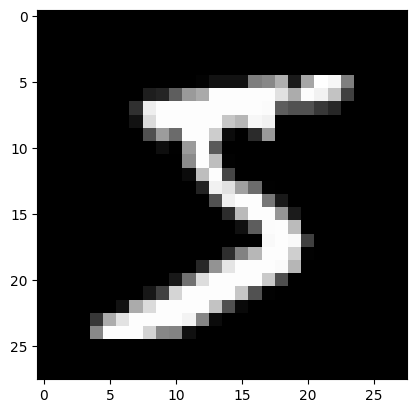

In [ ]:
plt.imshow(x_0.squeeze(0), cmap='gray')

## 1.3 Tensors

[PyTorch tensors](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) have a number of useful properies and methods. We can verify the data type:

In [11]:
x_0_tensor = trans(x_0)  # trans -> ToTensor()로 변화하는 이미지 픽셀 scale이 (0~255) -> (0, 1)로 정규화됨

In [12]:
x_0_tensor.shape

torch.Size([1, 28, 28])

In [13]:
x_0_tensor.dtype

torch.float32

We can verify the minimum and maximum values. PIL Images have a potential integer range of [0, 255], but the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) class converts it to a float range of [0.0, 1.0].

In [14]:
x_0_tensor.min()

tensor(0.)

In [15]:
x_0_tensor.max()

tensor(1.)

We can also view the size of each dimension. PyTorch uses a `C x H x W` convention, which means the first dimension is color channel, the second is height, and the third is width.

Since these images are black and white, there is only 1 color channel. The images are square being 28 pixels tall and wide:

We can also look at the values directly:

In [16]:
x_0_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

By default, a tensor is processed with a [CPU](https://www.arm.com/glossary/cpu).

In [17]:
x_0_tensor.device

device(type='cpu')

To move it to a GPU, we can use the `.cuda` method.

In [18]:
x_0_gpu = x_0_tensor.cuda()
x_0_gpu.device

device(type='cuda', index=0)

The `.cuda` method will fail if a GPU is not recognized by PyTorch. In order to make our code flexible, we can send our tensor `to` the `device` we identified at the start of this notebook. This way, our code will run much faster if a GPU is available, but the code will not break if there is no available GPU.

In [21]:
x_0_tensor.to(device).device

device(type='cuda', index=0)

Sometimes, it can be hard to interpret so many numbers. Thankfully, TorchVision can convert `C x H x W` tensors back into a PIL image with the [to_pil_image](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_pil_image.html) function.

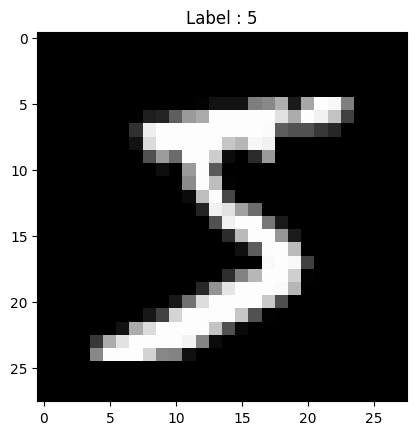

In [22]:
image = F.to_pil_image(x_0_tensor)

plt.title(f'Label : {y_0}')
plt.imshow(image, cmap='gray')

## 1.4 Preparing the Data for Training

### 1.4.2 DataLoaders

If our dataset is a deck of flash cards, a [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) defines how we pull cards from the deck to train an AI model. We could show our models the entire dataset at once. Not only does this take a lot of computational resources, but [research shows](https://arxiv.org/pdf/1804.07612) using a smaller batch of data is more efficient for model training.

For example, if our `batch_size` is 32, we will train our model by shuffling the deck and drawing 32 cards. We do not need to shuffle for validation as the model is not learning, but we will still use a `batch_size` to prevent memory errors.

The batch size is something the model developer decides, and the best value will depend on the problem being solved. Research shows 32 or 64 is sufficient for many machine learning problems and is the default in some machine learning frameworks, so we will use 32 here.

In [23]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [ ]:
train_loader

In [24]:
print(type(train_loader))
print(train_loader.dataset)
print(train_loader.dataset.data.shape)
print(train_loader.batch_size)

<class 'torch.utils.data.dataloader.DataLoader'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(    ToTensor())
torch.Size([60000, 28, 28])
32


In [ ]:
len(train_loader) # 60000  / 32(batch size)

1875

In [ ]:
len(valid_loader) # 10000 / 32 -> 313

313

In [25]:
data_iter = iter(train_loader)
batch = next(data_iter)
data, target = batch
data.shape, target.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1.5 Creating the Model

It's time to build the model! Neural networks are composed of layers where each layer performs a mathematical operation on the data it receives before passing it to the next layer. To start, we will create a "Hello World" level model made from 4 components:

1. A [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) used to convert n-dimensional data into a vector.
2. An input layer, the first layer of neurons
3. A hidden layer, another layor of neurons "hidden" between the input and output
4. An output layer, the last set of neurons which returns the final prediction from the model

More information about these layers is available in [this blog post](https://medium.com/@sarita_68521/basic-understanding-of-neural-network-structure-eecc8f149a23) by Sarita.

Let's create a `layers` variable to hold our list of layers.

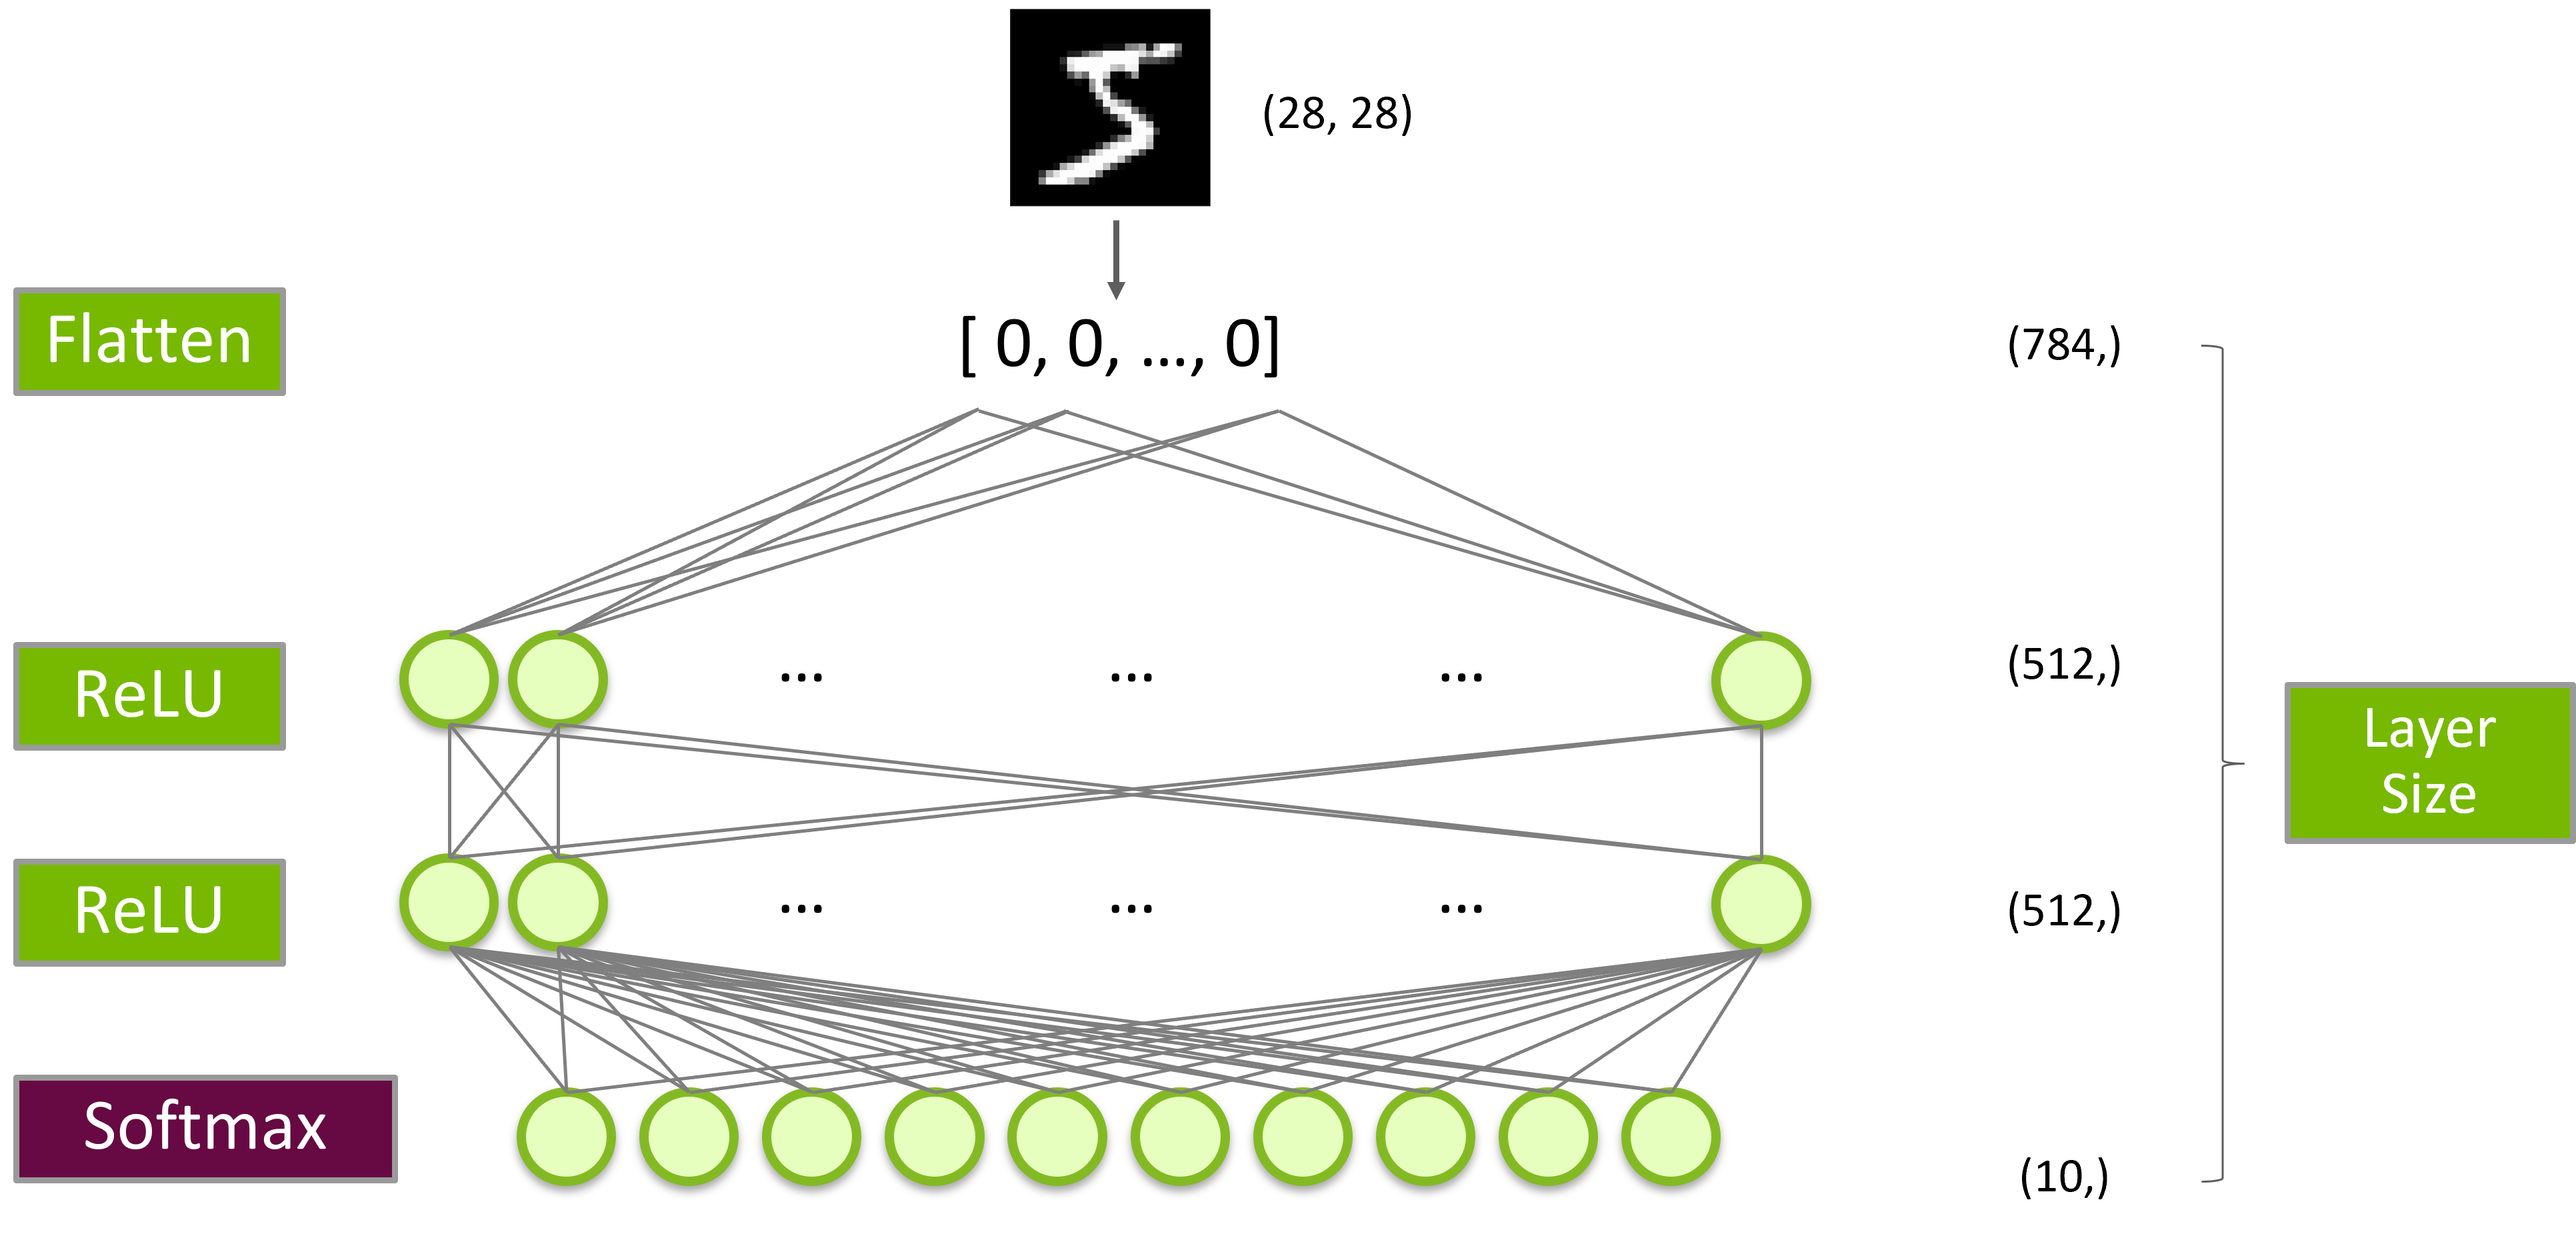

In [26]:
input_size = 1 * 28 * 28

In [57]:
n_classes = 10

model = nn.Sequential(
    nn.Flatten(),                # (1, 28*28)
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),                   # Activation for input
    nn.Linear(512, 512),         # Hidden
    nn.ReLU(),                   # Activation for hidden
    nn.Linear(512, n_classes)    # Output
)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

### 1.5.5 Compiling the Model

A [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model expects a sequence of arguments, not a list, so we can use the [* operator](https://docs.python.org/3/reference/expressions.html#expression-lists) to unpack our list of layers into a sequence. We can print the model to verify these layers loaded correctly.

Much like tensors, when the model is first initialized, it will be processed on a CPU. To have it process with a GPU, we can use `to(device)`.

In [58]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

To check which device a model is on, we can check which device the model parameters are on. Check out this [stack overflow](https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently) post for more information.

In [59]:
# 모델의 첫 번째 파라미터가 위치한 장치를 반환
next(model.parameters()).device

device(type='cuda', index=0)

In [60]:
next(model.parameters()).to(device).device

device(type='cuda', index=0)

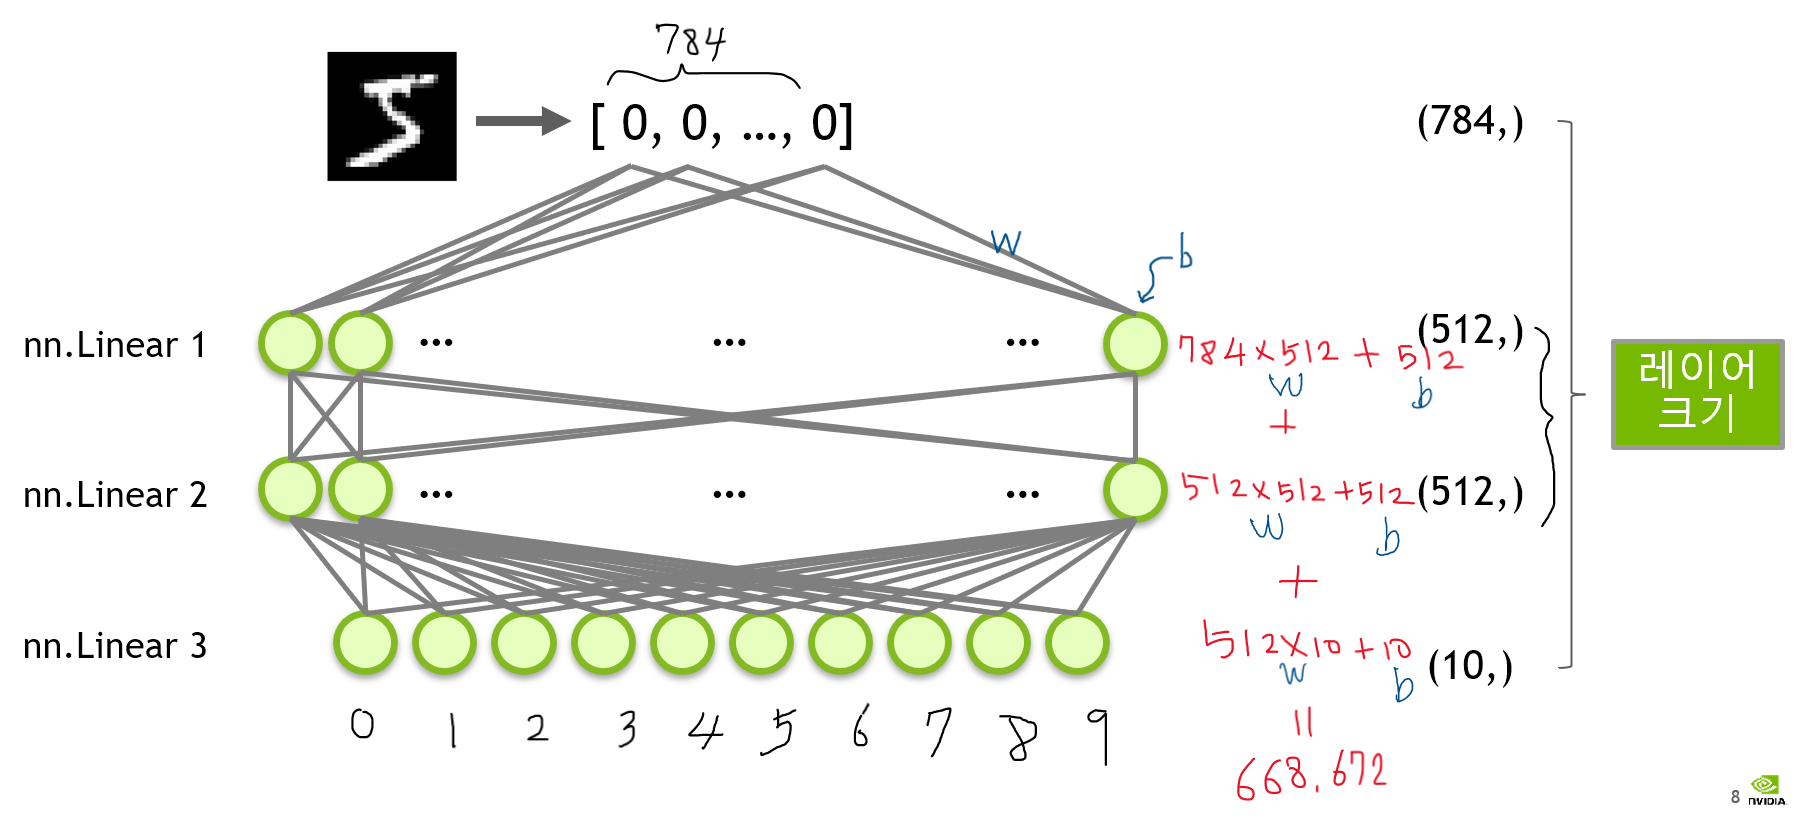

In [61]:
for param in model.parameters(): # 3개의 nn.Linear 계층의 weight, bias
    # print(param.shape, param)
    print(param.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [62]:
# colab에서는 torch.compile(model) 없어야 오류가 없음
# model = torch.compile(model)

[PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) introduced the ability to compile a model for faster performance. Learn more about it [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

## 1.6 Training the Model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put another way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

### 1.6.1 Loss and Optimization

Just like how teachers grade students, we need to provide the model a function in which to grade its answers. This is called a `loss function`. We will use a type of loss function called [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which is designed to grade if a model predicted the correct category from a group of categories.

In [63]:
loss_function = nn.CrossEntropyLoss()
loss_function

CrossEntropyLoss()

Next, we select an `optimizer` for our model. If the `loss_function` provides a grade, the optimizer tells the model how to learn from this grade to do better next time.

In [64]:
optimizer = Adam(model.parameters())

### 1.6.2 Calculating Accuracy

While the results of the loss function are effective in helping our model learn, the values can be difficult to interpret for humans. This is why data scientists often include other metrics like accuracy.

In order to accurately calculate accuracy, we should compare the number of correct classifications compared to the total number of predictions made. Since we're showing data to the model in batches, our accuracy can be calculated along with these batches.

First, the total number of predictions is the same size as our dataset. Let's assign the size of our datasets to `N` where `n` is synonymous with the `batch size`.

In [65]:
train_N = len(train_loader.dataset)  # 전체 train_set이 갯수 : 60,000 개
valid_N = len(valid_loader.dataset)  # 전체 valide_set의 갯수 : 10,000 개
train_N, valid_N

(60000, 10000)

In [66]:
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [67]:
train_loader.dataset.targets.shape

torch.Size([60000])

Next, we'll make a function to calculate the accuracy for each batch. The result is a fraction of the total accuracy, so we can add the accuracy of each batch together to get the total.

In [68]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [69]:
#############################################
## get_batch_accuracy(output, y, N) 보충 설명
############################################
output = torch.tensor([[0.1, 0.2, 0.7],
                       [0.8, 0.1, 0.1],
                       [0.3, 0.4, 0.3]])  # [Batch, Classes] : (3 x 3)
output.shape

torch.Size([3, 3])

In [70]:
# keepdim=True : 텐서의 차원이 입력과 동일하게 유지(2차원)
pred = output.argmax(dim=1, keepdim=True)
pred, pred.shape

(tensor([[2],
         [0],
         [1]]),
 torch.Size([3, 1]))

In [71]:
y = torch.tensor([2, 0, 0])  # [Batch]
print(y.shape)
y = y.view_as(pred)
print(y.shape)

torch.Size([3])
torch.Size([3, 1])


In [72]:
y

tensor([[2],
        [0],
        [0]])

In [73]:
pred.eq(y.view_as(pred)) # True : 1, False : 0

tensor([[ True],
        [ True],
        [False]])

In [74]:
correct = pred.eq(y.view_as(pred)).sum().item()
correct

##########################################################

2

### 1.6.3 The Train Function

Here is where everything comes together. Below is the function we've defined to train our model based on the training data. We will walk through each line of code in more detail later, but take a moment to review how it is structured. Can you recognize the variables we created earlier?

In [75]:
train_loss = []
train_acc = []

def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)

        optimizer.zero_grad()

        # batch_loss는 32개(batch 크기)의 평균 값
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)

    # after one epoch
    # len(train_loader) -> 전체 train_set(60000) / batct_size(32)
    avg_loss = loss/len(train_loader)
    train_loss.append(avg_loss)
    train_acc.append(accuracy)

    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(avg_loss, accuracy))

### 1.6.4 The Validate Function

Similarly, this is the code for validating the model with data it did not train on. Can you spot some differences with the `train` function?

In [76]:
valid_loss = []
valid_acc = []

def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)

    avg_loss = loss/len(valid_loader)
    valid_loss.append(avg_loss)
    valid_acc.append(accuracy)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(avg_loss, accuracy))

### 1.6.5 The Training Loop

To see how the model is progressing, we will alternated between training and validation. Just like how it might take a student a few times going through their deck of flash cards to learn all the concepts, the model will go through the training data multiple times to get a better and better understanding.

An `epoch` is one complete pass through the entire dataset. Let's train and validate the model for 5 `epochs` to see how it learns.

In [77]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 0.2019 Accuracy: 0.9390
Valid - Loss: 0.1136 Accuracy: 0.9631
Epoch: 1
Train - Loss: 0.0821 Accuracy: 0.9744
Valid - Loss: 0.0912 Accuracy: 0.9716
Epoch: 2
Train - Loss: 0.0581 Accuracy: 0.9817
Valid - Loss: 0.0874 Accuracy: 0.9724
Epoch: 3
Train - Loss: 0.0443 Accuracy: 0.9858
Valid - Loss: 0.0774 Accuracy: 0.9783
Epoch: 4
Train - Loss: 0.0347 Accuracy: 0.9893
Valid - Loss: 0.0693 Accuracy: 0.9805
Epoch: 5
Train - Loss: 0.0290 Accuracy: 0.9903
Valid - Loss: 0.0928 Accuracy: 0.9786
Epoch: 6
Train - Loss: 0.0245 Accuracy: 0.9920
Valid - Loss: 0.0860 Accuracy: 0.9790
Epoch: 7
Train - Loss: 0.0209 Accuracy: 0.9934
Valid - Loss: 0.1058 Accuracy: 0.9762
Epoch: 8
Train - Loss: 0.0212 Accuracy: 0.9936
Valid - Loss: 0.1106 Accuracy: 0.9777
Epoch: 9
Train - Loss: 0.0202 Accuracy: 0.9938
Valid - Loss: 0.1133 Accuracy: 0.9805


In [78]:
train_loss, train_acc

([0.20187526196042696,
  0.08211912337071263,
  0.058142846429751566,
  0.04428175895838067,
  0.034742851669620725,
  0.02901507962080529,
  0.02449725256418145,
  0.0208627065767287,
  0.02121614551359359,
  0.020247290013919332],
 [0.938983333333347,
  0.9743666666666948,
  0.9817166666667005,
  0.985800000000038,
  0.9892833333333754,
  0.9903166666667081,
  0.9920333333333764,
  0.9934166666667099,
  0.9935500000000446,
  0.9937666666667111])

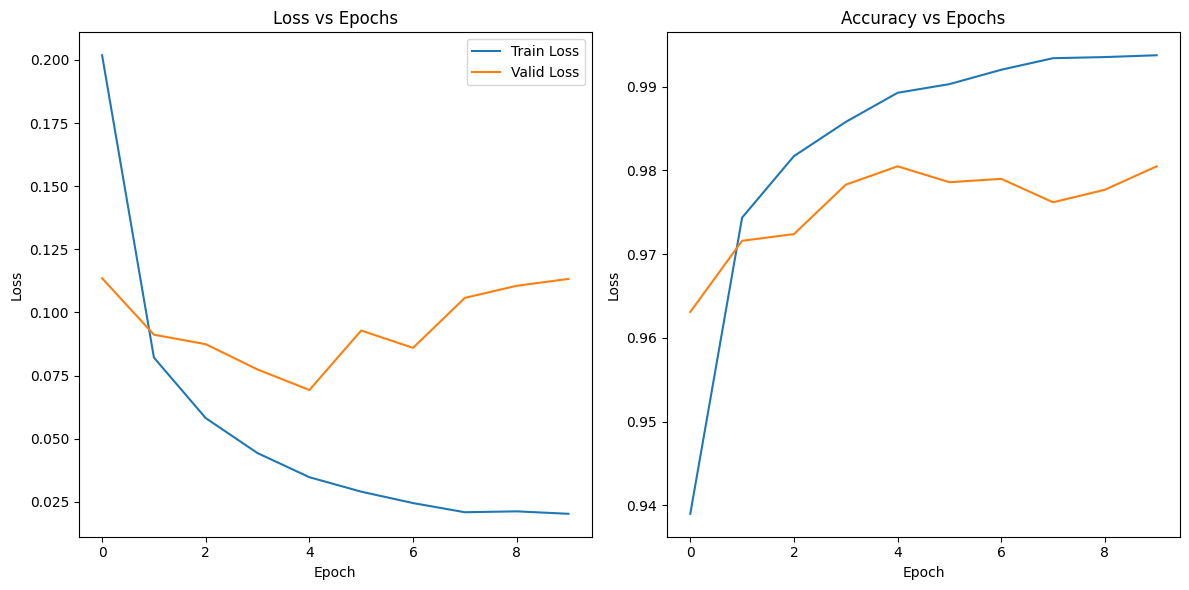

In [79]:
# 데이터 시각화
plt.figure(figsize = (12, 6))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy vs Epochs')
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy vs Epochs')
plt.tight_layout()
plt.show()


We're already close to 100%! Let's see if it's true by testing it on our original sample. We can use our model like a function:

## Prediction

In [80]:
prediction = model(x_0_gpu) # 5
prediction

tensor([[-27.2048, -14.7860, -22.0763,  -0.0659, -26.4510,  17.5478, -17.5538,
         -19.9240, -20.3659,  -4.2614]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

There should be ten numbers, each corresponding to a different output neuron. Thanks to how the data is structured, the index of each number matches the corresponding handwritten number. The 0th index is a prediction for a handwritten 0, the 1st index is a prediction for a handwritten 1, and so on.

We can use the `argmax` function to find the index of the highest value.

In [81]:
p_label = prediction.argmax(dim=1, keepdim=True)
pred_label = p_label.squeeze(0).item()
pred_label

5

Did it get it right?

In [82]:
true_label = y_0  # 실제 정답 (이미 정수인 경우)
true_label

5

In [83]:
# 이미지를 CPU로 옮기고 numpy로 변환
image = x_0_gpu[0].detach().cpu().squeeze().numpy()
image.shape

(28, 28)

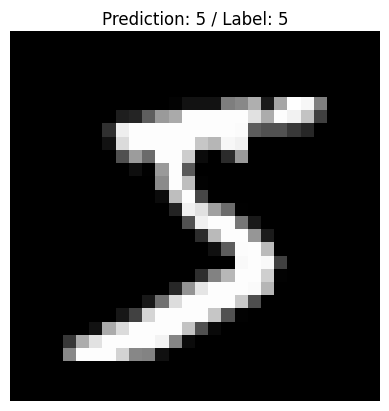

In [84]:
# 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Prediction: {pred_label} / Label: {true_label}')
plt.axis('off')
plt.show()

## 1.7 Summary

The model did quite well! The accuracy quickly reached close to 100%, as did the validation accuracy. We now have a model that can be used to accurately detect and classify hand-written images.

The next step would be to use this model to classify new not-yet-seen handwritten images. This is called [inference](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/). We'll explore the process of inference in a later exercise.

It's worth taking a moment to appreciate what we've done here. Historically, the expert systems that were built to do this kind of task were extremely complicated, and people spent their careers building them (check out the references on the [official MNIST page](http://yann.lecun.com/exdb/mnist/) and the years milestones were reached).

MNIST is not only useful for its historical influence on Computer Vision, but it's also a great [benchmark](http://www.cs.toronto.edu/~serailhydra/publications/tbd-iiswc18.pdf) and debugging tool. Having trouble getting a fancy new machine learning architecture working? Check it against MNIST. If it can't learn on this dataset, chances are it won't learn on more complicated images and datasets.

### 1.7.1 Clear the Memory

Before moving on, please execute the following cell to clear up the GPU memory. This is required to move on to the next notebook.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### 1.7.2 Next

In this section you learned how to build and train a simple neural network for image classification. In the next section, you will be asked to build your own neural network and perform data preparation to solve a different image classification problem.